In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import torch

In [2]:
object_categories = ['aeroplane', 'bicycle', 'bird', 'boat',
                     'bottle', 'bus', 'car', 'cat', 'chair',
                     'cow', 'diningtable', 'dog', 'horse',
                     'motorbike', 'person', 'pottedplant',
                     'sheep', 'sofa', 'train', 'tvmonitor']

sns.set(rc={'text.usetex' : True})

In [3]:
def coef_p(x, m):
    return -m * np.exp(-m * x)

def sigmoid(x):
    return 1./(1. + np.exp(-x))

In [4]:
xs = np.linspace(-150, 150, 1000)   
global_cam = np.load('../global_cam_by_class.npy')
global_vec = np.mean(global_cam, axis=(1,2))
print(global_vec)

[0.12834466 0.10228772 0.07720348 0.09457465 0.04803186 0.11550845
 0.07815445 0.09887417 0.07509874 0.08668583 0.10275163 0.07995779
 0.0970743  0.10396102 0.11321446 0.05811152 0.10454589 0.10195397
 0.12891178 0.06884266]


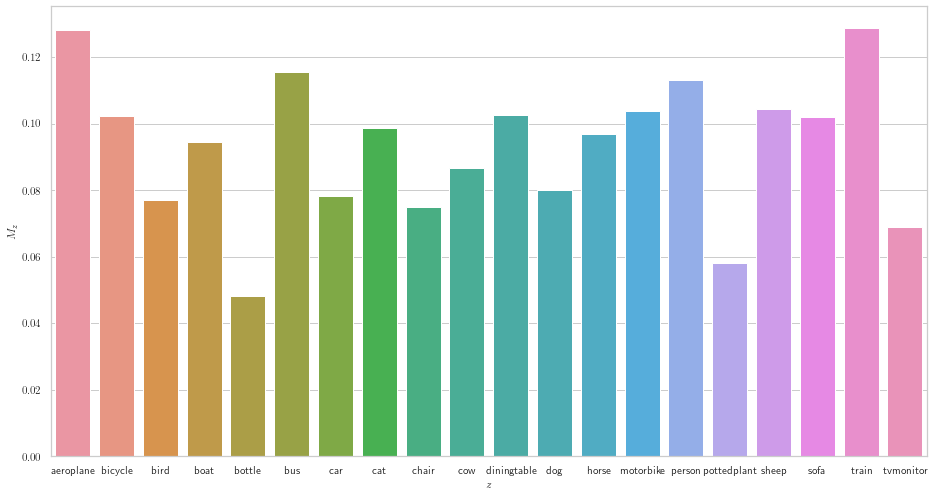

In [18]:
d = {}
d['$M_z$'] = global_vec
d['$z$'] = object_categories
df = pd.DataFrame(data=d)



sns.set(rc={'figure.figsize':(15.7,8.27)})
sns.set(font_scale=1)
sns.set_style("whitegrid")
sns.despine(left=True)
g = sns.barplot(x="$z$", y="$M_z$", data=dfm, dodge=False)
plt.savefig('global_cam_val.pdf', bbox_inches='tight', pad_inches=0)

## Verify gradient computation

In [19]:
logits = torch.randn(1, 20)
labels = torch.zeros(1, 20)
labels[0][4] = 1
logits.requires_grad = True

logits_wg = logits.unsqueeze(2).unsqueeze(2) * torch.from_numpy(global_cam)
logits_wg = torch.mean(logits_wg, dim=(2,3))
bce_loss = torch.nn.BCEWithLogitsLoss(reduction='mean')(logits_wg, labels)

our_grad = []
for idx, m in enumerate(global_vec):
    s = logits[0][idx].detach()
    if idx == 4:
        our_grad += [coef_p(s, m) * sigmoid(m * s)/20]
    else:
        our_grad += [m * sigmoid(m * s)/20]
our_grad = torch.tensor(our_grad)
bce_loss.backward()
print(our_grad)
print(logits.grad)

tensor([ 0.0028,  0.0028,  0.0019,  0.0024, -0.0012,  0.0031,  0.0019,  0.0024,
         0.0020,  0.0021,  0.0024,  0.0021,  0.0023,  0.0028,  0.0028,  0.0014,
         0.0028,  0.0022,  0.0032,  0.0018])
tensor([[ 0.0028,  0.0028,  0.0019,  0.0024, -0.0012,  0.0031,  0.0019,  0.0024,
          0.0020,  0.0021,  0.0024,  0.0021,  0.0023,  0.0028,  0.0028,  0.0014,
          0.0028,  0.0022,  0.0032,  0.0018]])


## Visualize gradient for each class

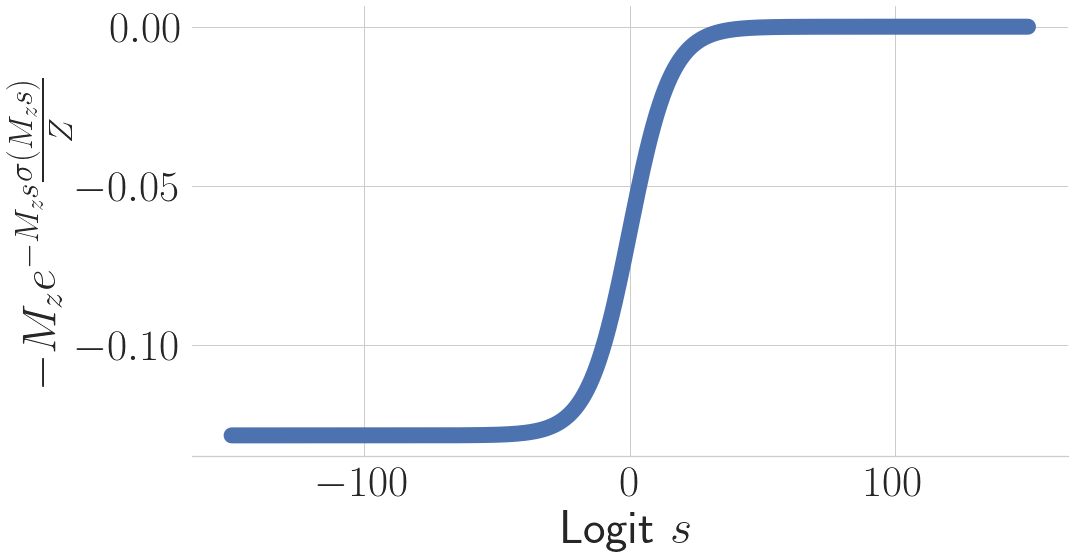

In [18]:
plt.clf()

dp = {}
dp['Logit $s$'] = xs

global_vec = np.mean(global_cam, axis=(1,2))
ys = []
for idx, m in enumerate(global_vec):
    if idx == 0:
        dp[object_categories[idx]] = coef_p(xs, m) * sigmoid(m * xs)

df = pd.DataFrame(data=dp)
dfm = df.melt('Logit $s$', var_name='Class', value_name='$-M_ze^{-M_zs}\\frac{\sigma(M_zs)}{Z}$')

sns.set(font_scale=4)
sns.set_style("whitegrid")
sns.lineplot(data=dfm, x="Logit $s$", y='$-M_ze^{-M_zs}\\frac{\sigma(M_zs)}{Z}$', hue="Class", legend=False, linewidth=16)
sns.despine(left=True)
plt.savefig('grad_pos_aeroplane.pdf', bbox_inches='tight', pad_inches=0)

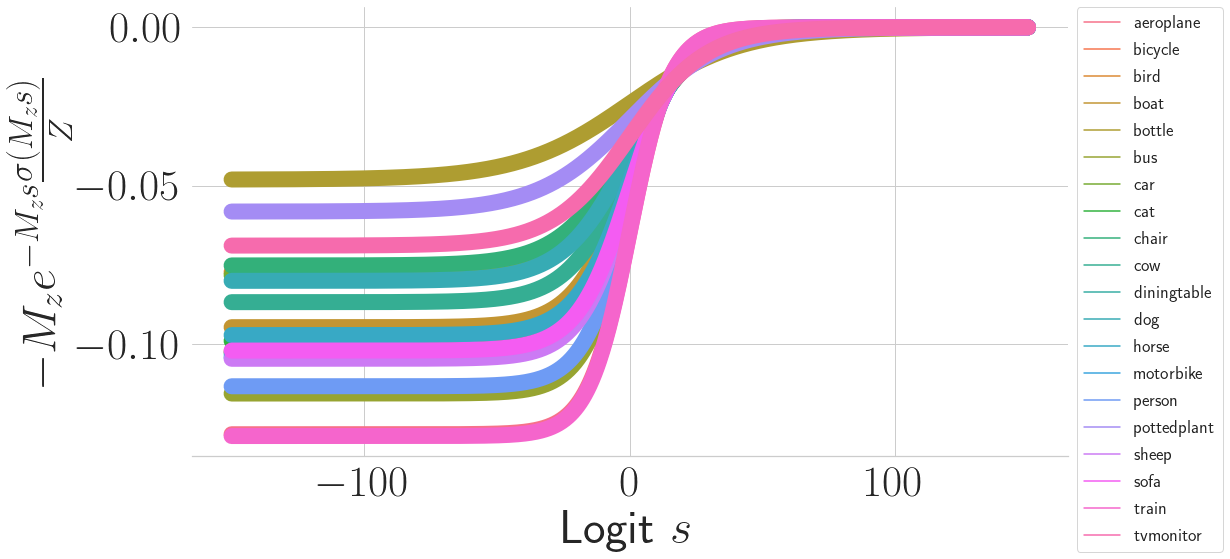

In [19]:
plt.clf()

dp = {}
dp['Logit $s$'] = xs

global_vec = np.mean(global_cam, axis=(1,2))
ys = []
for idx, m in enumerate(global_vec):
    dp[object_categories[idx]] = coef_p(xs, m) * sigmoid(m * xs)


df = pd.DataFrame(data=dp)
dfm = df.melt('Logit $s$', var_name='Class', value_name='$-M_ze^{-M_zs}\\frac{\sigma(M_zs)}{Z}$')

sns.color_palette("Spectral", as_cmap=True)
sns.set(font_scale=4)
sns.set_style("whitegrid")
sns.lineplot(data=dfm, x="Logit $s$", y='$-M_ze^{-M_zs}\\frac{\sigma(M_zs)}{Z}$', hue="Class", linewidth=16)
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0., prop={'size': 18})
sns.despine(left=True)
plt.savefig('grad_pos_all.pdf', bbox_inches='tight', pad_inches=0)

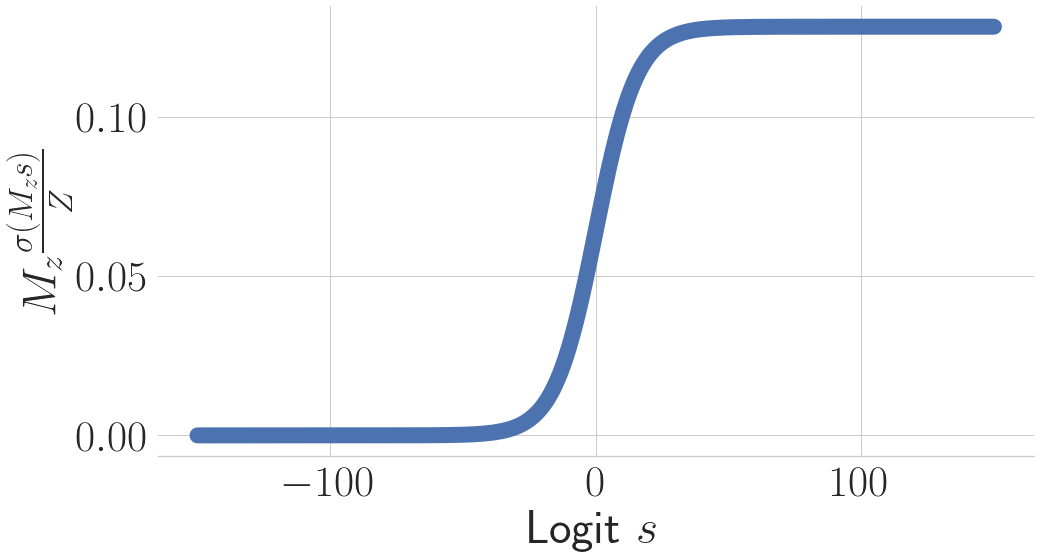

In [20]:
plt.clf()
plt.cla()  

dn = {}
dn['Logit $s$'] = xs

ys = []
for idx, m in enumerate(global_vec):
    if idx == 0:
        dn[object_categories[idx]] = m * sigmoid(m * xs)

df = pd.DataFrame(data=dn)
dfm = df.melt('Logit $s$', var_name='Class', value_name='$M_z\\frac{\sigma(M_zs)}{Z}$')

sns.set(rc={'figure.figsize':(15.7,8.27)})

sns.set(font_scale=4)
sns.set_style("whitegrid")
sns.lineplot(data=dfm, x="Logit $s$", y='$M_z\\frac{\sigma(M_zs)}{Z}$', hue="Class", legend=False, linewidth=16)
sns.despine(left=True)
plt.savefig('grad_neg_aeroplane.pdf', bbox_inches='tight', pad_inches=0)

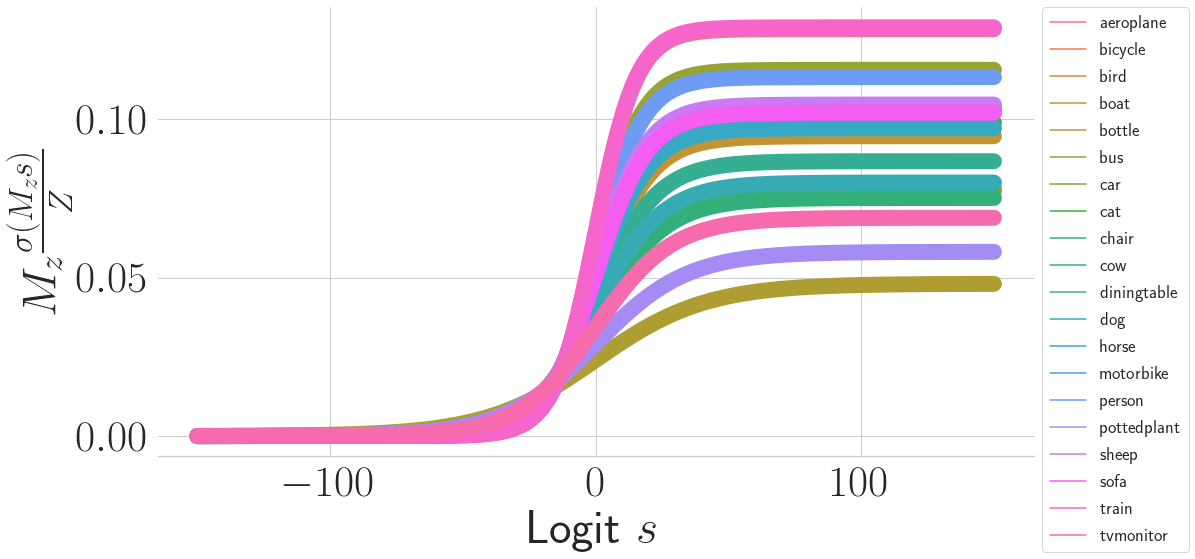

In [21]:
dn = {}
dn['Logit $s$'] = xs

ys = []
for idx, m in enumerate(global_vec):
    dn[object_categories[idx]] = m * sigmoid(m * xs)

df = pd.DataFrame(data=dn)
dfm = df.melt('Logit $s$', var_name='Class', value_name='$M_z\\frac{\sigma(M_zs)}{Z}$')

sns.set(rc={'figure.figsize':(15.7,8.27)})

sns.set(font_scale=4)
sns.set_style("whitegrid")
sns.lineplot(data=dfm, x="Logit $s$", y='$M_z\\frac{\sigma(M_zs)}{Z}$', hue="Class", linewidth=16)
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0., prop={'size': 18})
sns.despine(left=True)
plt.savefig('grad_neg_all.pdf', bbox_inches='tight', pad_inches=0)

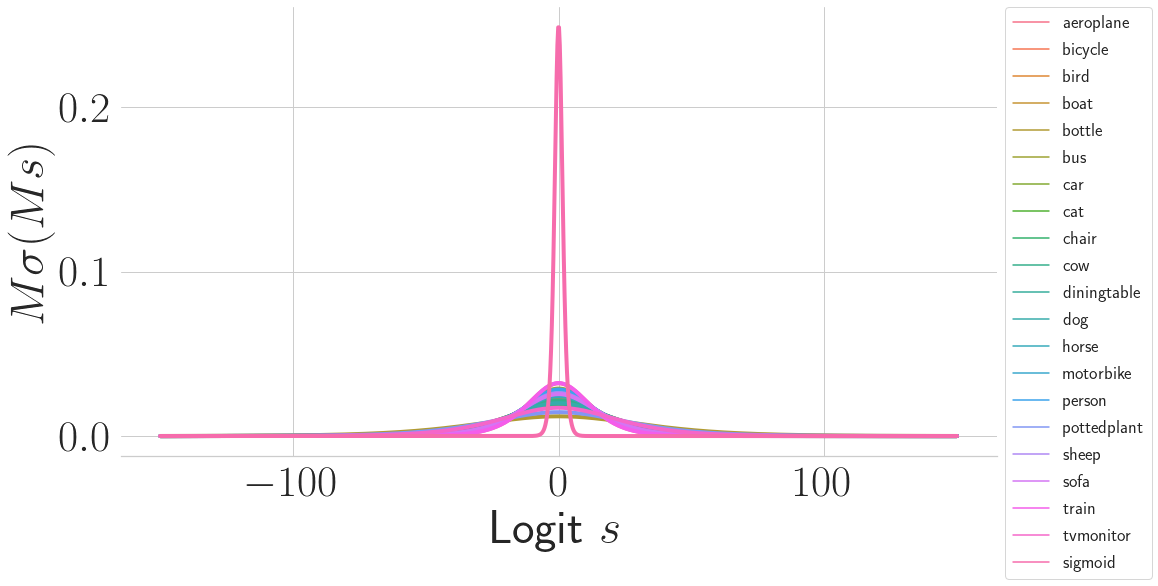

In [22]:
xs = np.linspace(-150, 150, 1000) 

def grad_sigmoid(m,x):
    return (m*np.exp(-m*x))/((np.exp(-m*x)+1)*(np.exp(-m*x)+1))

dn = {}
dn['Logit $s$'] = xs

ys = []
for idx, m in enumerate(global_vec):
    dn[object_categories[idx]] = grad_sigmoid(m, xs)
dn['sigmoid'] = (np.exp(-xs))/((np.exp(-xs) + 1) * (np.exp(-xs) + 1))

df = pd.DataFrame(data=dn)
dfm = df.melt('Logit $s$', var_name='Class', value_name='$M\sigma(Ms)$')

sns.lineplot(data=dfm, x="Logit $s$", y="$M\sigma(Ms)$", hue="Class", linewidth=4)

sns.set(rc={'figure.figsize':(15.7,8.27)})
sns.set(font_scale=4)
sns.set_style("whitegrid")

plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0., prop={'size': 18})
sns.despine(left=True)

plt.savefig('grad_sig.pdf', bbox_inches='tight', pad_inches=0)

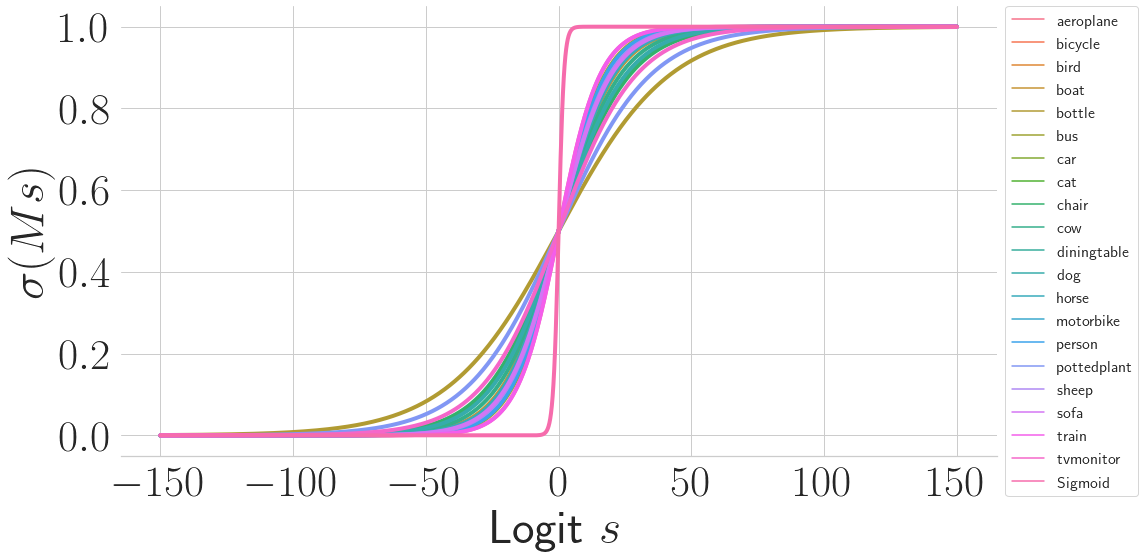

In [23]:
d = {}
d['Logit $s$'] = xs

ys = []
for idx, m in enumerate(global_vec):
    d[object_categories[idx]] = sigmoid(m * xs)
d['Sigmoid'] = sigmoid(xs)

df = pd.DataFrame(data=d)
dfm = df.melt('Logit $s$', var_name='Class', value_name='$\sigma(Ms)$')

sns.lineplot(data=dfm, x="Logit $s$", y="$\sigma(Ms)$", hue="Class", linewidth=4)

sns.set(rc={'figure.figsize':(15.7,8.27)})
sns.set_style("whitegrid")
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0., prop={'size': 16})
sns.despine(left=True)
plt.savefig('sigmoid.pdf', bbox_inches='tight', pad_inches=0)

In [24]:
# C2AM
mious = {'C$^2$AM: mIoU 69.5': np.array([0.88659327, 0.71814539, 0.3884691 , 0.80320139, 0.57592809,
        0.65333002, 0.85757262, 0.73941466, 0.82153491, 0.39183911,
        0.84328199, 0.52388143, 0.77543608, 0.82585977, 0.79823379,
        0.69704805, 0.57564149, 0.85182085, 0.64462221, 0.65316124,
        0.57029861]), 'CAM: mIoU 65.3': np.array([0.87917766, 0.67227121, 0.35942197, 0.76256142, 0.58875524,
        0.61210626, 0.80195505, 0.69033153, 0.74489198, 0.33625327,
        0.7751565 , 0.41982922, 0.72092112, 0.7774972 , 0.75148308,
        0.68446215, 0.52643946, 0.82553838, 0.56916316, 0.64415595,
        0.57197679]), 'Labels': ['background'] + object_categories}  


df = pd.DataFrame(data=mious)
dfm = df.melt('Labels', var_name='Algorithm', value_name='mIoU')


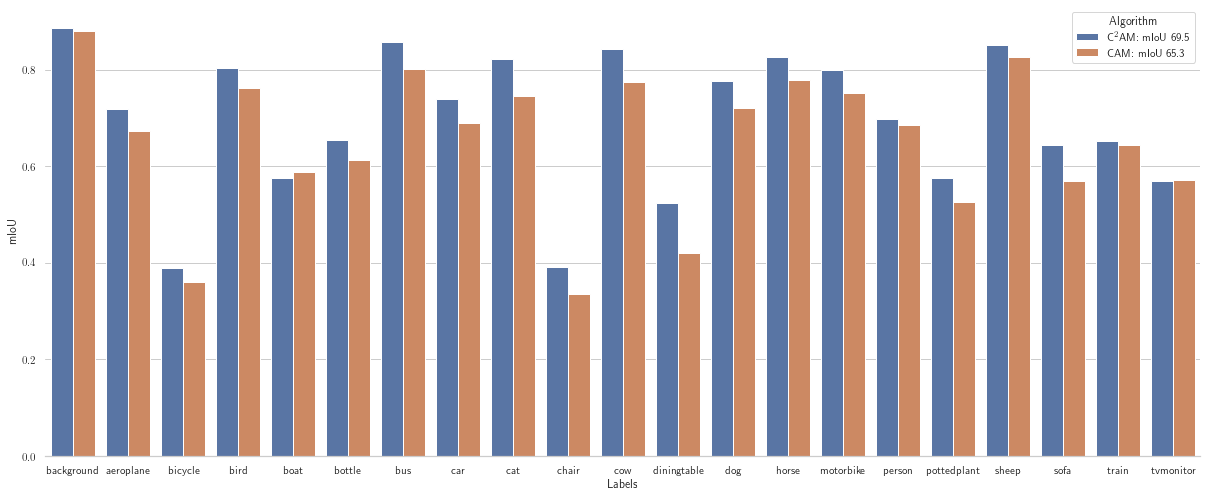

In [25]:
sns.set(rc={'figure.figsize':(20.7,8.27)})
sns.set_style("whitegrid")
sns.barplot(x="Labels", y="mIoU", hue="Algorithm", data=dfm)
sns.despine(left=True)